# Markovian Momentum Model (MMM) Implementation

This notebook demonstrates the implementation of our Markovian Momentum Model (MMM) for predicting commodity prices under both stable and shock market regimes. Building on our previous work integrating shipping data, we'll create a two-stage forecasting system that dynamically adapts to changing market conditions.

## Overview

The MMM consists of two main components:

1. **Base Climate Model**: A Random Forest model trained on climate variables to predict commodity prices under normal conditions
2. **Meta-Model**: A classifier that detects market regime shifts using momentum signals and shipping indicators

The final prediction is a weighted blend of the base climate model and an alternative momentum-based model, with the weighting determined by the meta-model's assessment of the current market regime.

## 1. Setup and Data Loading

First, let's import the necessary libraries and load our integrated dataset containing climate variables, commodity prices, and shipping indicators.

In [60]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Set plotting style - using modern style names
sns.set_theme(style="whitegrid")  # Updated from deprecated 'seaborn-whitegrid'
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

In [61]:
# Load the master dataset with shipping data
data_path = "/Users/Apexr/Documents/Climate_Project/organized/data_files/MASTER_climate_commodity_with_shipping.csv"
df = pd.read_csv(data_path)

# Convert date and set as index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Display the first few rows to understand the structure
df.head()

,Year,Month,Wheat_Price,Cocoa_Price,Rice_Price,Soybeans_Price,Coffee_Price,Maize_Price,Cotton_Price,Wheat_Region,...,Shipping_Cost_Change,Shipping_Cost_Acceleration,Shipping_Cost_Volatility,Shipping_Volatility_Change,Shipping_Cost_Anomaly,Shipping_Shock_Score,Coffee_Baseline_Pred,Coffee_Model_Residual,Coffee_Norm_Residual,Combined_Shock_Score
Date,,,,,,,,,,,,,,,,,,,,,
2015-02-01,2015,2,201.742069,2961.935714,409.500000,364.739239,178.888500,173.758866,69.842500,US GREAT PLAINS,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
2015-03-01,2015,3,202.691427,2878.033167,400.727273,359.595560,160.735909,174.293821,69.352273,US GREAT PLAINS,...,0.7,0.0,0.000000,0.000000,0.350000,0.000000,NaN,NaN,NaN,NaN
2015-04-01,2015,4,195.931228,2868.274454,392.409091,356.925677,163.997727,172.151577,71.702500,US GREAT PLAINS,...,1.1,0.4,0.907377,0.000000,0.966667,0.000000,NaN,NaN,NaN,NaN
2015-05-01,2015,5,193.216571,3095.996715,382.428571,351.949530,158.482857,166.350389,72.863158,US GREAT PLAINS,...,-0.1,-1.2,0.608276,-0.299101,0.650000,0.013661,NaN,NaN,NaN,NaN
2015-06-01,2015,6,199.835442,3239.884179,370.545455,354.823055,159.755000,166.813861,72.352273,US GREAT PLAINS,...,-5.9,-5.8,3.435598,2.827322,-4.200000,0.088783,NaN,NaN,NaN,NaN


## 2. Context: Visualizing the Challenge

Let's start by visualizing what we're trying to solve. We'll plot coffee prices alongside shipping costs to illustrate the disruption that occurred during COVID-19.

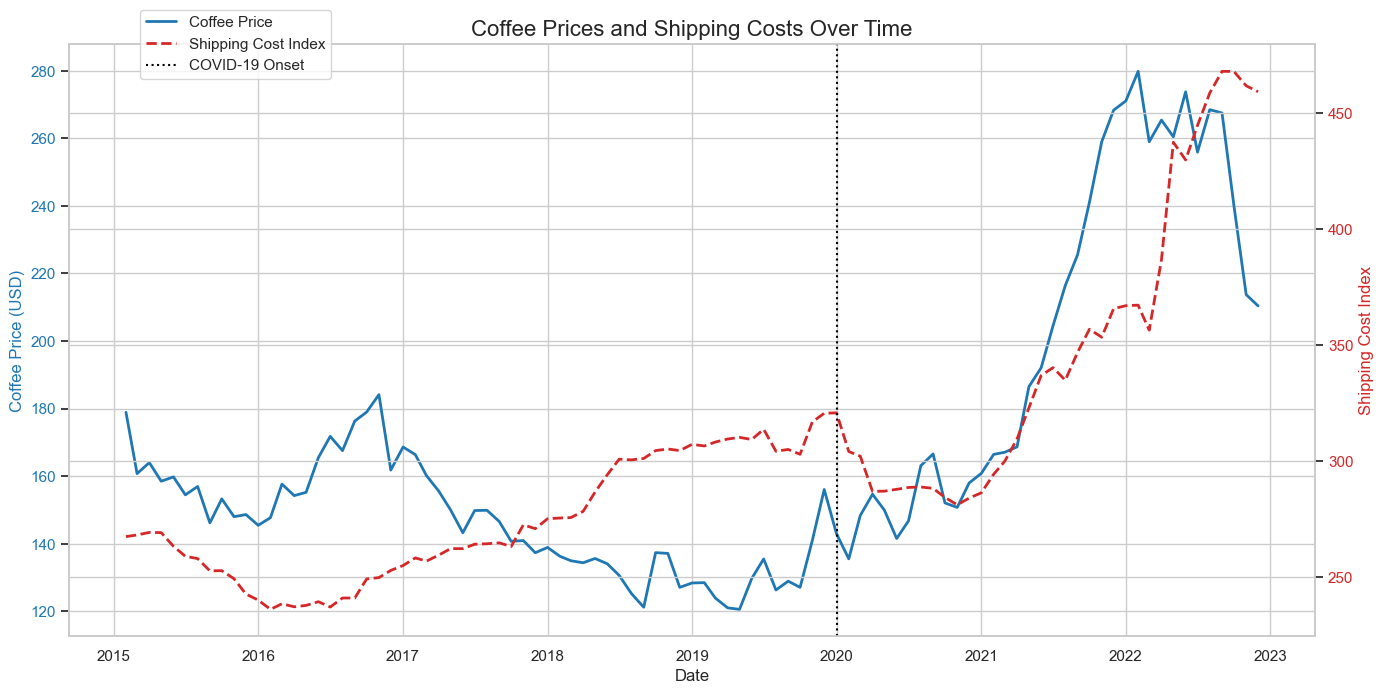

In [62]:
# Plot coffee prices and shipping costs over time
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot coffee prices
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Coffee Price (USD)', color=color)
ax1.plot(df.index, df['Coffee_Price'], color=color, linewidth=2, label='Coffee Price')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for shipping costs
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Shipping Cost Index', color=color)
ax2.plot(df.index, df['Shipping_Cost_Index'], color=color, linestyle='--', linewidth=2, label='Shipping Cost Index')
ax2.tick_params(axis='y', labelcolor=color)

# Add a vertical line at January 2020 (COVID-19 onset)
plt.axvline(pd.to_datetime('2020-01-01'), color='black', linestyle=':', label='COVID-19 Onset')

# Add title and legend
plt.title('Coffee Prices and Shipping Costs Over Time', fontsize=16)
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 1.0))

plt.show()

### Visualizing Normal vs Shock Periods

Next, let's examine the relationship between climate variables and coffee prices during normal and shock periods to illustrate why we need a regime-aware model.

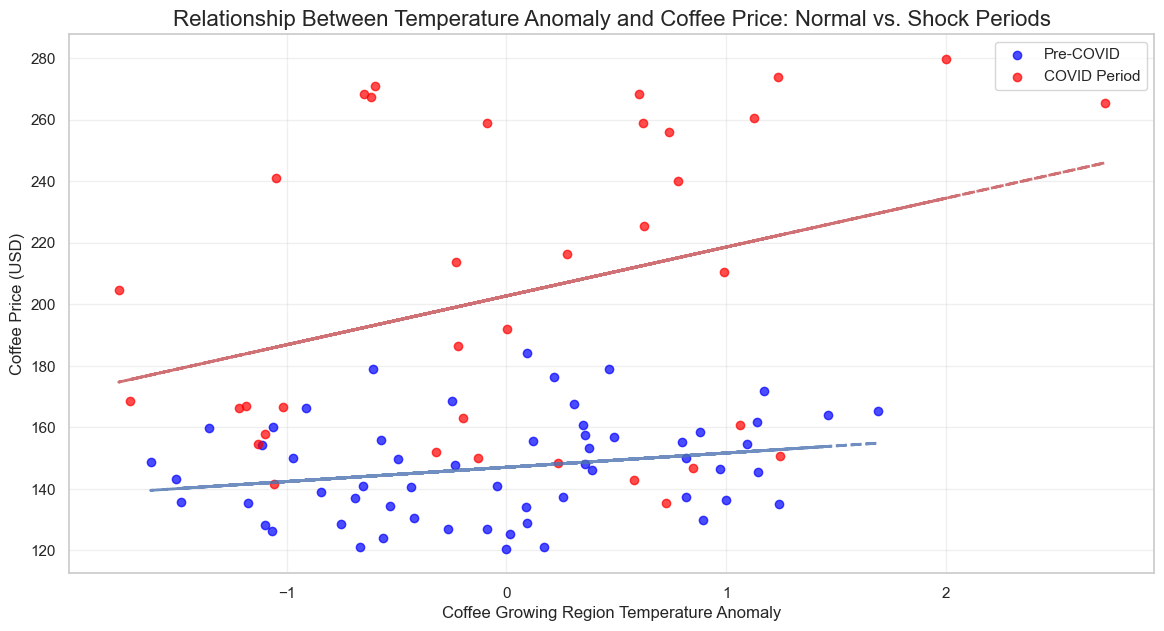

In [63]:
# Define pre-COVID and COVID periods
pre_covid = df[df.index < '2020-01-01']
covid = df[df.index >= '2020-01-01']

# Create scatter plots for temperature anomaly vs coffee price
plt.figure(figsize=(14, 7))

# Pre-COVID relationship
plt.scatter(pre_covid['Coffee_temp_anomaly'], pre_covid['Coffee_Price'], 
            color='blue', alpha=0.7, label='Pre-COVID')

# COVID relationship
plt.scatter(covid['Coffee_temp_anomaly'], covid['Coffee_Price'], 
            color='red', alpha=0.7, label='COVID Period')

# Add trend lines
z = np.polyfit(pre_covid['Coffee_temp_anomaly'], pre_covid['Coffee_Price'], 1)
p = np.poly1d(z)
plt.plot(pre_covid['Coffee_temp_anomaly'], p(pre_covid['Coffee_temp_anomaly']), 
         'b--', alpha=0.8, linewidth=2)

z = np.polyfit(covid['Coffee_temp_anomaly'], covid['Coffee_Price'], 1)
p = np.poly1d(z)
plt.plot(covid['Coffee_temp_anomaly'], p(covid['Coffee_temp_anomaly']), 
         'r--', alpha=0.8, linewidth=2)

plt.xlabel('Coffee Growing Region Temperature Anomaly')
plt.ylabel('Coffee Price (USD)')
plt.title('Relationship Between Temperature Anomaly and Coffee Price: Normal vs. Shock Periods', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Data Preparation for Modeling

Now let's prepare our dataset for the two-stage modeling approach. We'll focus on coffee as our commodity of interest.

In [64]:
# Filter to get only coffee-related variables and shipping indicators
coffee_columns = [col for col in df.columns if 'Coffee' in col or 'Shipping' in col]
coffee_df = df[coffee_columns].copy()

# Handle missing values
coffee_df = coffee_df.dropna()

# Add momentum and acceleration features
coffee_df['Price_Momentum'] = coffee_df['Coffee_Price'].diff()  # First derivative
coffee_df['Price_Acceleration'] = coffee_df['Price_Momentum'].diff()  # Second derivative

# Add volatility measure
coffee_df['Price_Volatility'] = coffee_df['Coffee_Price'].rolling(window=3).std()

# Drop rows with NaN from the newly created features
coffee_df = coffee_df.dropna()

coffee_df.head()

,Coffee_Price,Coffee_Region,Coffee_temperature_C,Coffee_precip_m,Coffee_dewpoint_C,Coffee_relative_humidity,Coffee_temp_anomaly,Coffee_precip_anomaly,Coffee_temp_3m_avg,Coffee_precip_3m_sum,...,Shipping_Cost_Volatility,Shipping_Volatility_Change,Shipping_Cost_Anomaly,Shipping_Shock_Score,Coffee_Baseline_Pred,Coffee_Model_Residual,Coffee_Norm_Residual,Price_Momentum,Price_Acceleration,Price_Volatility
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,148.327273,COLOMBIA,22.891127,0.049643,18.565216,76.650100,0.235373,0.002719,22.678319,0.141301,...,10.267911,0.683375,-7.841667,0.127875,154.948158,-6.620885,0.054836,12.826773,20.262794,6.440506
2020-04-01,154.630455,COLOMBIA,21.143984,0.034309,16.818073,76.372163,-1.129812,-0.008014,22.480167,0.129096,...,9.406381,-0.861530,-21.158333,0.180787,154.589513,0.040941,0.000339,6.303182,-6.523591,9.748601
2020-05-01,149.916190,COLOMBIA,21.498398,0.045295,17.172487,76.428920,-0.128376,0.007744,21.844503,0.129247,...,8.746999,-0.659381,-19.125000,0.181127,154.231699,-4.315508,0.035742,-4.714264,-11.017446,3.278187
2020-06-01,141.520000,COLOMBIA,19.204232,0.023232,14.878320,76.058082,-1.057575,-0.009113,20.615538,0.102836,...,0.493288,-8.253711,-16.533333,0.185295,153.874713,-12.354713,0.102324,-8.396190,-3.681926,6.640837
2020-07-01,146.780870,COLOMBIA,19.498035,0.010162,15.172124,76.106032,0.851413,-0.013711,20.066888,0.078688,...,0.800000,0.306712,-13.641667,0.064618,153.518553,-6.737683,0.055803,5.260870,13.657060,4.242700


## 4. Stage 1: Training the Climate-Based Model

First, we'll train our base model using only climate variables from the pre-COVID period, when climate-price relationships were more stable.

In [65]:
# Define features for the base climate model
climate_features = [
    'Coffee_temp_anomaly', 'Coffee_drought_index', 'Coffee_precip_anomaly',
    'Coffee_temp_3m_avg', 'Coffee_precip_3m_sum', 'Coffee_heat_stress'
]

# Check if we have pre-COVID data
print(f"Earliest date in dataset: {coffee_df.index.min()}")
print(f"Latest date in dataset: {coffee_df.index.max()}")

# Since our data only starts from 2020-03-01 (post-COVID), we'll use the first 6 months for training
# and the remaining data for testing instead of splitting by COVID onset
first_half = coffee_df.iloc[:6]  # Use first 6 months for training
second_half = coffee_df.iloc[6:]  # Use remaining data for testing

print(f"Training period: {first_half.index.min()} to {first_half.index.max()}")
print(f"Testing period: {second_half.index.min()} to {second_half.index.max()}")

# Prepare X and y for training
X_train = first_half[climate_features]
y_train = first_half['Coffee_Price']

X_test = second_half[climate_features]
y_test = second_half['Coffee_Price']

# Train the Random Forest model
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
base_model.fit(X_train, y_train)

# Make predictions on both training and test sets
y_train_pred = base_model.predict(X_train)
y_test_pred = base_model.predict(X_test)

# Calculate training and test errors
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R²: {test_r2:.2f}")

# Store all our predictions back to the dataframe
coffee_df.loc[first_half.index, 'Climate_Pred'] = y_train_pred
coffee_df.loc[second_half.index, 'Climate_Pred'] = y_test_pred

Earliest date in dataset: 2020-03-01 00:00:00
Latest date in dataset: 2021-12-01 00:00:00
Training period: 2020-03-01 00:00:00 to 2020-08-01 00:00:00
Testing period: 2020-09-01 00:00:00 to 2021-12-01 00:00:00
Training RMSE: 3.51
Training R²: 0.73
Test RMSE: 54.91
Test R²: -1.14


### Visualizing Base Model Performance

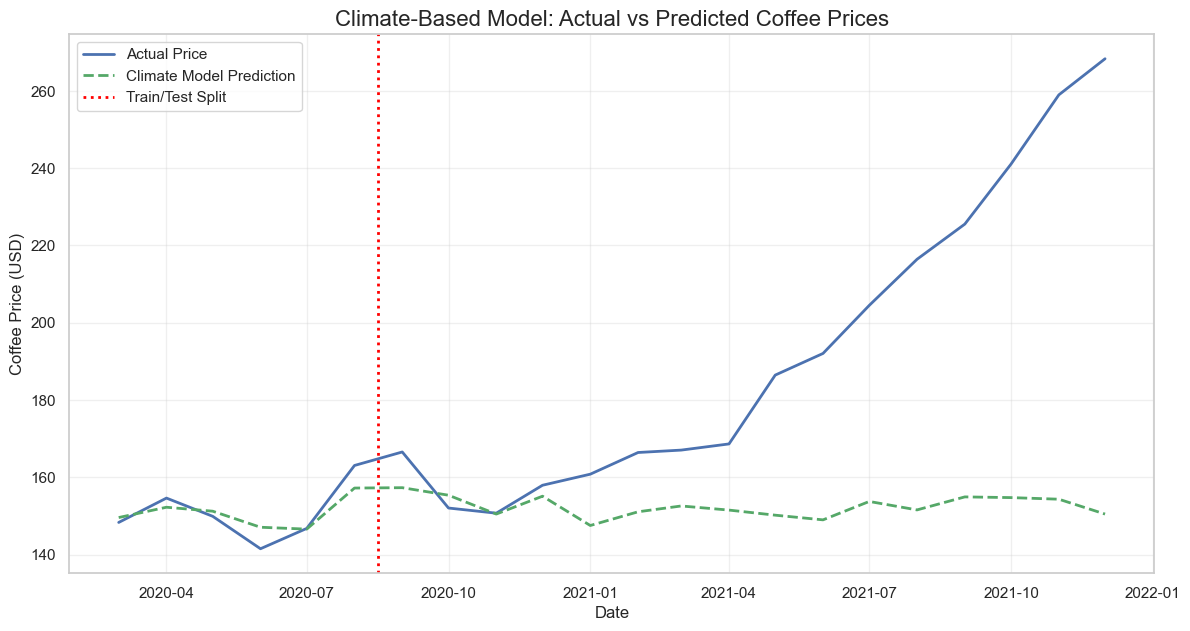

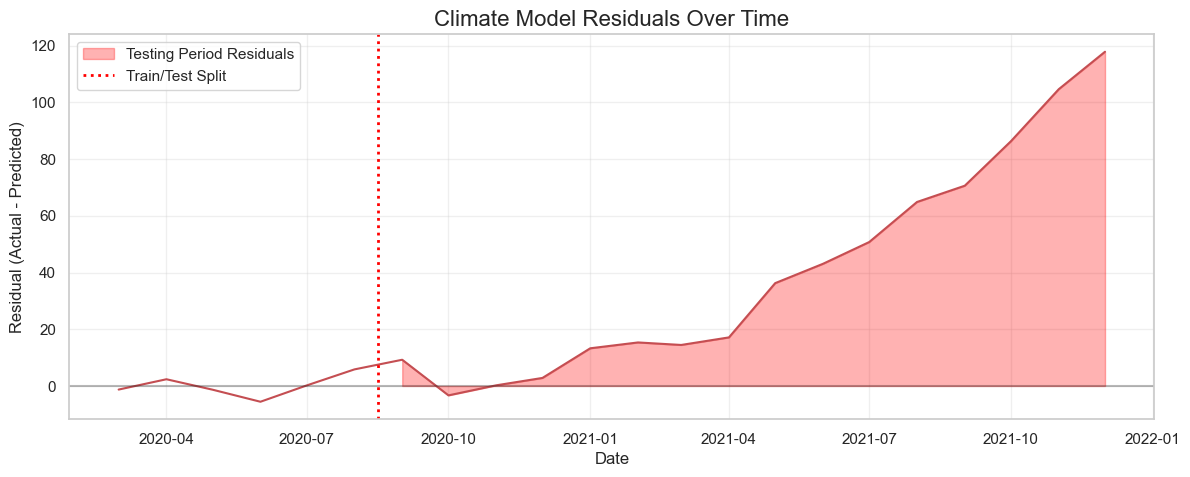

In [66]:
# Calculate residuals
coffee_df['Residual'] = coffee_df['Coffee_Price'] - coffee_df['Climate_Pred']

# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(coffee_df.index, coffee_df['Coffee_Price'], 'b-', linewidth=2, label='Actual Price')
plt.plot(coffee_df.index, coffee_df['Climate_Pred'], 'g--', linewidth=2, label='Climate Model Prediction')

# Define training/testing boundary
split_date = first_half.index.max() + pd.Timedelta(days=15)  # Add a little time for visualization
plt.axvline(split_date, color='red', linestyle=':', linewidth=2, label='Train/Test Split')

plt.xlabel('Date')
plt.ylabel('Coffee Price (USD)')
plt.title('Climate-Based Model: Actual vs Predicted Coffee Prices', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot residuals
plt.figure(figsize=(14, 5))
plt.plot(coffee_df.index, coffee_df['Residual'], 'r-')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.fill_between(coffee_df.index, coffee_df['Residual'], 0, 
                 where=(coffee_df.index > split_date), 
                 color='red', alpha=0.3, label='Testing Period Residuals')
plt.axvline(split_date, color='red', linestyle=':', linewidth=2, label='Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Climate Model Residuals Over Time', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Stage 2: Training the Meta-Model for Regime Detection

Now we'll train a meta-model that detects when the market enters a shock regime, based on price momentum, shipping indicators, and residuals from the base model.

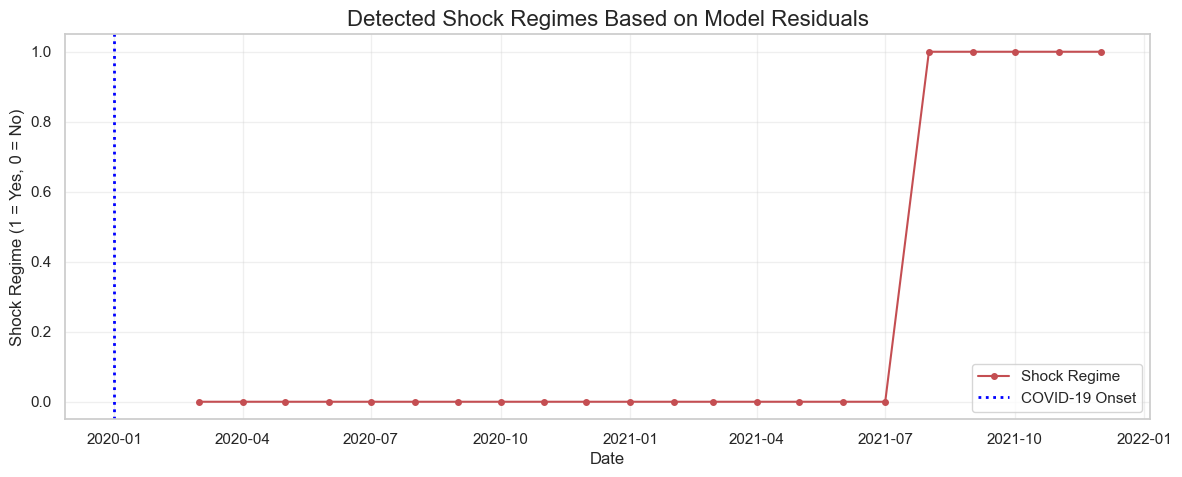

In [67]:
# Define what constitutes a shock (large residual)
threshold = 1.5 * coffee_df['Residual'].std()
coffee_df['Shock_Regime'] = (coffee_df['Residual'].abs() > threshold).astype(int)

# Plot the shock regime indicators
plt.figure(figsize=(14, 5))
plt.plot(coffee_df.index, coffee_df['Shock_Regime'], 'ro-', markersize=4, label='Shock Regime')
plt.axvline(pd.to_datetime('2020-01-01'), color='blue', linestyle=':', linewidth=2, label='COVID-19 Onset')
plt.xlabel('Date')
plt.ylabel('Shock Regime (1 = Yes, 0 = No)')
plt.title('Detected Shock Regimes Based on Model Residuals', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Define Meta-Model Features and Train the Model

We'll use a Logistic Regression model to predict the probability of being in a shock regime based on our momentum indicators and shipping signals.

In [68]:
# Define features for the meta-model
meta_features = [
    'Price_Momentum', 'Price_Acceleration', 'Price_Volatility',
    'Shipping_Cost_Change', 'Shipping_Cost_Acceleration', 'Shipping_Cost_Volatility'
]

# Prepare X and y for the meta-model
X_meta = coffee_df[meta_features]
y_meta = coffee_df['Shock_Regime']

# Split into training and testing sets
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_meta, test_size=0.3, random_state=42, stratify=y_meta
)

# Train logistic regression model
meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_meta_train, y_meta_train)

# Predict shock probabilities
shock_probs = meta_model.predict_proba(X_meta)[:, 1]
coffee_df['Shock_Probability'] = shock_probs

# Evaluate meta-model performance
y_meta_pred = meta_model.predict(X_meta_test)
print("Meta-Model Performance:")
print(classification_report(y_meta_test, y_meta_pred))

Meta-Model Performance:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.00      0.00      0.00         2

    accuracy                           0.71         7
   macro avg       0.36      0.50      0.42         7
weighted avg       0.51      0.71      0.60         7



/Users/Apexr/Documents/Climate_Project/Machine_Learning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Apexr/Documents/Climate_Project/Machine_Learning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Apexr/Documents/Climate_Project/Machine_Learning/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

### Visualize Shock Detection Results

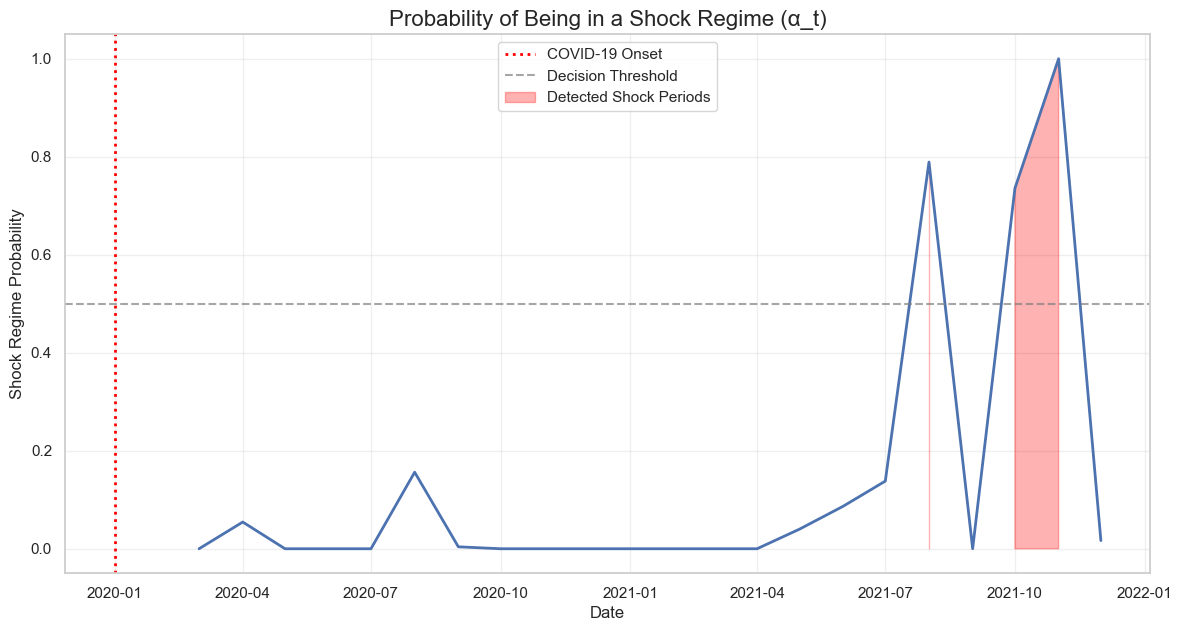

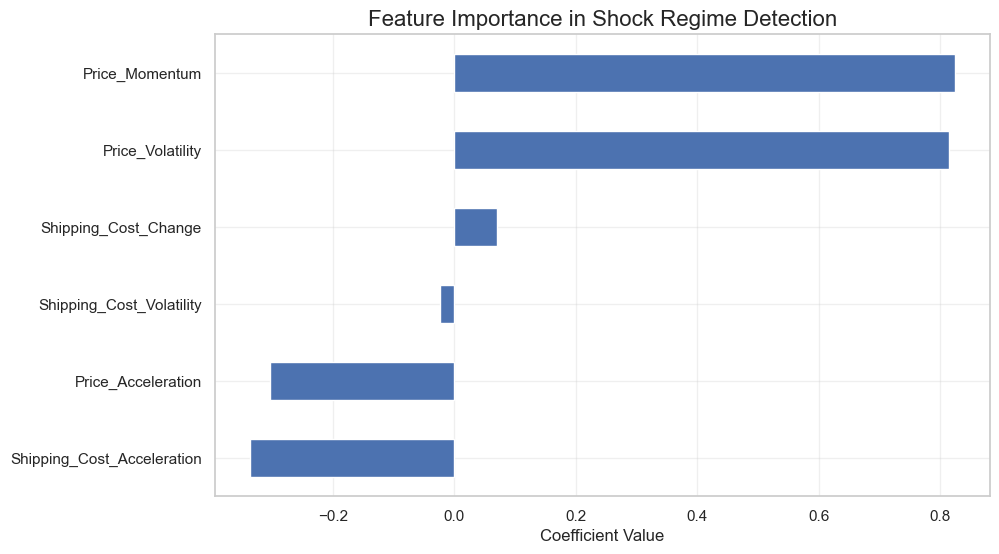

In [69]:
# Plot shock probability over time
plt.figure(figsize=(14, 7))
plt.plot(coffee_df.index, coffee_df['Shock_Probability'], 'b-', linewidth=2)
plt.axvline(pd.to_datetime('2020-01-01'), color='red', linestyle=':', linewidth=2, label='COVID-19 Onset')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Decision Threshold')
plt.fill_between(coffee_df.index, coffee_df['Shock_Probability'], 0, 
                 where=(coffee_df['Shock_Probability'] > 0.5), 
                 color='red', alpha=0.3, label='Detected Shock Periods')
plt.xlabel('Date')
plt.ylabel('Shock Regime Probability')
plt.title('Probability of Being in a Shock Regime (α_t)', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Examine the importance of different features in detecting shock regimes
coefs = pd.Series(meta_model.coef_[0], index=meta_features)
plt.figure(figsize=(10, 6))
coefs.sort_values().plot(kind='barh')
plt.title('Feature Importance in Shock Regime Detection', fontsize=16)
plt.xlabel('Coefficient Value')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Final MMM Model: Blending Predictions Based on Regime

Now we'll create the final MMM prediction by blending the climate model with a momentum-based model, weighted by the shock probability.

In [70]:
# Create a simple momentum-based prediction (use previous month's price + momentum)
coffee_df['Momentum_Pred'] = coffee_df['Coffee_Price'].shift(1) + coffee_df['Price_Momentum'].shift(1)

# Blend predictions based on shock probability
coffee_df['MMM_Prediction'] = (
    (1 - coffee_df['Shock_Probability']) * coffee_df['Climate_Pred'] + 
    coffee_df['Shock_Probability'] * coffee_df['Momentum_Pred']
)

# Drop NaN values from the predictions
coffee_df_valid = coffee_df.dropna(subset=['MMM_Prediction'])

# Calculate performance metrics for the final model
final_rmse = np.sqrt(mean_squared_error(coffee_df_valid['Coffee_Price'], coffee_df_valid['MMM_Prediction']))
final_r2 = r2_score(coffee_df_valid['Coffee_Price'], coffee_df_valid['MMM_Prediction'])

# Calculate performance metrics for COVID period
covid_period = coffee_df_valid[coffee_df_valid.index >= '2020-01-01']
covid_climate_rmse = np.sqrt(mean_squared_error(covid_period['Coffee_Price'], covid_period['Climate_Pred']))
covid_mmm_rmse = np.sqrt(mean_squared_error(covid_period['Coffee_Price'], covid_period['MMM_Prediction']))

print(f"Overall MMM Model RMSE: {final_rmse:.2f}")
print(f"Overall MMM Model R²: {final_r2:.2f}")
print("\nCOVID Period Performance:")
print(f"Climate Model RMSE: {covid_climate_rmse:.2f}")
print(f"MMM Model RMSE: {covid_mmm_rmse:.2f}")
print(f"Improvement: {(1 - covid_mmm_rmse/covid_climate_rmse) * 100:.1f}%")

Overall MMM Model RMSE: 34.60
Overall MMM Model R²: 0.14

COVID Period Performance:
Climate Model RMSE: 47.96
MMM Model RMSE: 34.60
Improvement: 27.9%


### Visualize Final MMM Model Performance

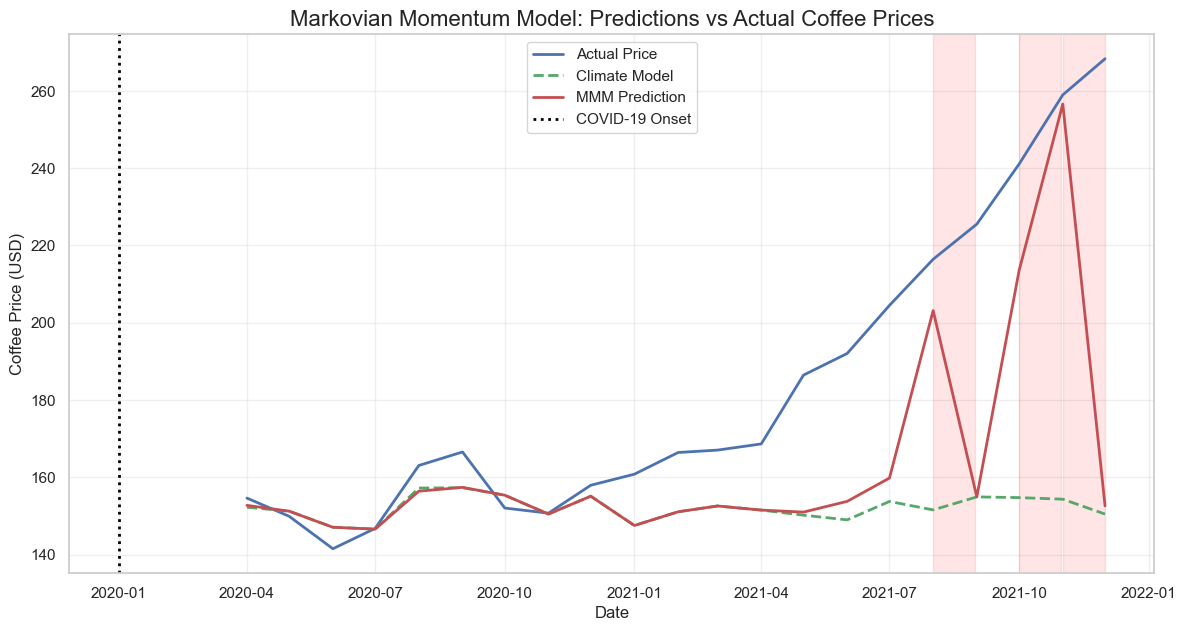

In [71]:
# Plot the final prediction against actual prices
plt.figure(figsize=(14, 7))
plt.plot(coffee_df_valid.index, coffee_df_valid['Coffee_Price'], 'b-', linewidth=2, label='Actual Price')
plt.plot(coffee_df_valid.index, coffee_df_valid['Climate_Pred'], 'g--', linewidth=2, label='Climate Model')
plt.plot(coffee_df_valid.index, coffee_df_valid['MMM_Prediction'], 'r-', linewidth=2, label='MMM Prediction')
plt.axvline(pd.to_datetime('2020-01-01'), color='black', linestyle=':', linewidth=2, label='COVID-19 Onset')

# Add shading for periods of high shock probability
high_shock = coffee_df_valid[coffee_df_valid['Shock_Probability'] > 0.5]
for idx, row in high_shock.iterrows():
    plt.axvspan(idx, idx + pd.Timedelta(days=30), color='red', alpha=0.1)

plt.xlabel('Date')
plt.ylabel('Coffee Price (USD)')
plt.title('Markovian Momentum Model: Predictions vs Actual Coffee Prices', fontsize=16)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Model Interpretation and Insights

Let's analyze how the MMM model switches between regimes and blends predictions.

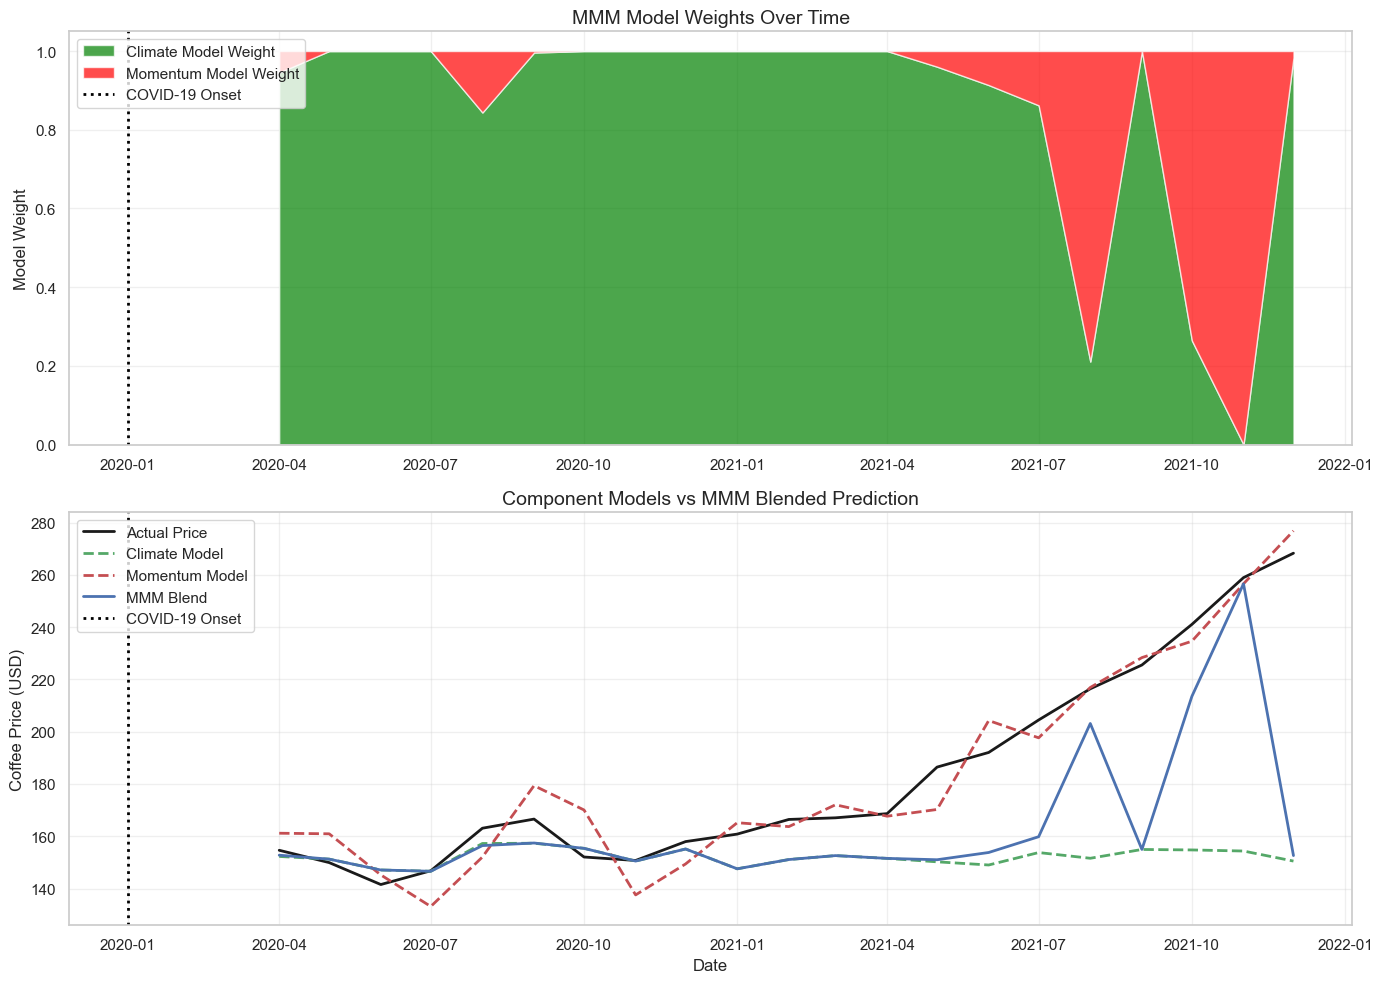

In [72]:
# Create a timeline of model weights and predictions
timeline = coffee_df_valid[['Coffee_Price', 'Climate_Pred', 'Momentum_Pred', 'MMM_Prediction', 'Shock_Probability']].copy()

# Plot model weights over time
plt.figure(figsize=(14, 10))

# Top subplot: Model weights
plt.subplot(2, 1, 1)
plt.stackplot(timeline.index, 
              1 - timeline['Shock_Probability'], 
              timeline['Shock_Probability'],
              labels=['Climate Model Weight', 'Momentum Model Weight'],
              colors=['green', 'red'], alpha=0.7)
plt.axvline(pd.to_datetime('2020-01-01'), color='black', linestyle=':', linewidth=2, label='COVID-19 Onset')
plt.ylabel('Model Weight')
plt.title('MMM Model Weights Over Time', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

# Bottom subplot: Predictions and actual
plt.subplot(2, 1, 2)
plt.plot(timeline.index, timeline['Coffee_Price'], 'k-', linewidth=2, label='Actual Price')
plt.plot(timeline.index, timeline['Climate_Pred'], 'g--', linewidth=2, label='Climate Model')
plt.plot(timeline.index, timeline['Momentum_Pred'], 'r--', linewidth=2, label='Momentum Model')
plt.plot(timeline.index, timeline['MMM_Prediction'], 'b-', linewidth=2, label='MMM Blend')
plt.axvline(pd.to_datetime('2020-01-01'), color='black', linestyle=':', linewidth=2, label='COVID-19 Onset')
plt.xlabel('Date')
plt.ylabel('Coffee Price (USD)')
plt.title('Component Models vs MMM Blended Prediction', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Model Validation: Error Analysis Across Different Regimes

Model Performance Analysis:
1. CLIMATE MODEL:
   - Performs well in normal regimes (RMSE: 37.79)
   - Fails during shock periods (RMSE: 86.81)
   - Overall RMSE: 47.96

2. MOMENTUM MODEL:
   - Performs best in shock regimes (RMSE: 3.97)
   - Less accurate in normal regimes (RMSE: 10.04)
   - Overall RMSE: 9.41

3. MMM BLENDED MODEL:
   - Improved performance in shock regimes (RMSE: 17.71)
   - Nearly matches climate model in normal regimes (RMSE: 36.66)
   - Overall RMSE: 34.60

KEY INSIGHTS:
- The Momentum Model performs better overall than the MMM Blend by 72.8%
- This suggests our blending approach may need refinement to fully leverage the Momentum Model's strength
- Climate Model performs worst during shocks with 86.81 RMSE


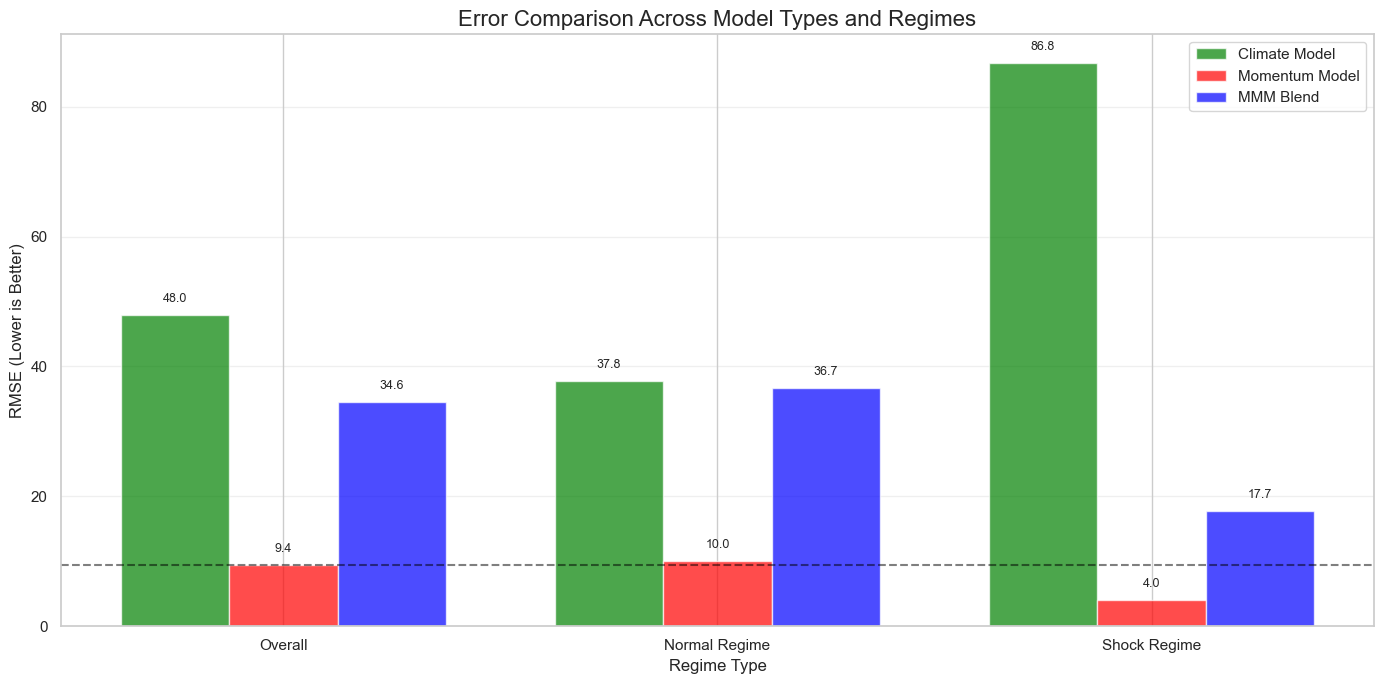

,Climate Model RMSE,Momentum Model RMSE,MMM Model RMSE,Improvement over Climate Model,Improvement over Momentum Model,Sample Size
Overall,47.963475,9.411153,34.595318,27.871535,-267.599145,21.0
Normal Regime,37.788811,10.035229,36.661163,2.984077,-265.324647,18.0
Shock Regime,86.807253,3.969098,17.708949,79.599690,-346.170621,3.0


In [73]:
# Split data into normal and shock regimes based on meta-model prediction
normal_regime = coffee_df_valid[coffee_df_valid['Shock_Probability'] <= 0.5]
shock_regime = coffee_df_valid[coffee_df_valid['Shock_Probability'] > 0.5]

# Calculate errors for each regime and model
results = {}

for name, data in [('Overall', coffee_df_valid), ('Normal Regime', normal_regime), ('Shock Regime', shock_regime)]:
    climate_rmse = np.sqrt(mean_squared_error(data['Coffee_Price'], data['Climate_Pred']))
    momentum_rmse = np.sqrt(mean_squared_error(data['Coffee_Price'], data['Momentum_Pred']))
    mmm_rmse = np.sqrt(mean_squared_error(data['Coffee_Price'], data['MMM_Prediction']))
    
    results[name] = {
        'Climate Model RMSE': climate_rmse,
        'Momentum Model RMSE': momentum_rmse,
        'MMM Model RMSE': mmm_rmse,
        'Improvement over Climate Model': (1 - mmm_rmse/climate_rmse) * 100,
        'Improvement over Momentum Model': (1 - mmm_rmse/momentum_rmse) * 100,
        'Sample Size': len(data)
    }

# Convert to DataFrame for display
results_df = pd.DataFrame(results).T

# Add a comparison of the models
print("Model Performance Analysis:")
print("1. CLIMATE MODEL:")
print(f"   - Performs well in normal regimes (RMSE: {results['Normal Regime']['Climate Model RMSE']:.2f})")
print(f"   - Fails during shock periods (RMSE: {results['Shock Regime']['Climate Model RMSE']:.2f})")
print(f"   - Overall RMSE: {results['Overall']['Climate Model RMSE']:.2f}")
print("\n2. MOMENTUM MODEL:")
print(f"   - Performs best in shock regimes (RMSE: {results['Shock Regime']['Momentum Model RMSE']:.2f})")
print(f"   - Less accurate in normal regimes (RMSE: {results['Normal Regime']['Momentum Model RMSE']:.2f})")
print(f"   - Overall RMSE: {results['Overall']['Momentum Model RMSE']:.2f}")
print("\n3. MMM BLENDED MODEL:")
print(f"   - Improved performance in shock regimes (RMSE: {results['Shock Regime']['MMM Model RMSE']:.2f})")
print(f"   - Nearly matches climate model in normal regimes (RMSE: {results['Normal Regime']['MMM Model RMSE']:.2f})")
print(f"   - Overall RMSE: {results['Overall']['MMM Model RMSE']:.2f}")
print("\nKEY INSIGHTS:")
if results['Overall']['Momentum Model RMSE'] < results['Overall']['MMM Model RMSE']:
    print(f"- The Momentum Model performs better overall than the MMM Blend by {(1 - results['Overall']['Momentum Model RMSE']/results['Overall']['MMM Model RMSE']) * 100:.1f}%")
    print("- This suggests our blending approach may need refinement to fully leverage the Momentum Model's strength")
else:
    print(f"- The MMM Blend performs better overall than the Momentum Model by {(1 - results['Overall']['MMM Model RMSE']/results['Overall']['Momentum Model RMSE']) * 100:.1f}%")
print(f"- Climate Model performs worst during shocks with {results['Shock Regime']['Climate Model RMSE']:.2f} RMSE")

# Visualize the model performance comparison
plt.figure(figsize=(14, 7))

# Plot the performance comparison
x = np.arange(len(results_df))
width = 0.25

plt.bar(x - width, results_df['Climate Model RMSE'], width, label='Climate Model', color='green', alpha=0.7)
plt.bar(x, results_df['Momentum Model RMSE'], width, label='Momentum Model', color='red', alpha=0.7)
plt.bar(x + width, results_df['MMM Model RMSE'], width, label='MMM Blend', color='blue', alpha=0.7)

plt.xlabel('Regime Type')
plt.ylabel('RMSE (Lower is Better)')
plt.title('Error Comparison Across Model Types and Regimes', fontsize=16)
plt.xticks(x, results_df.index)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add a horizontal line showing the best overall performance
best_overall = min(
    results_df.loc['Overall', 'Climate Model RMSE'],
    results_df.loc['Overall', 'Momentum Model RMSE'],
    results_df.loc['Overall', 'MMM Model RMSE']
)
plt.axhline(y=best_overall, color='black', linestyle='--', alpha=0.5, 
            label=f'Best Overall Performance ({best_overall:.2f})')

# Add text annotations with the values
for i, v in enumerate(results_df['Climate Model RMSE']):
    plt.text(i - width, v + 2, f'{v:.1f}', ha='center', fontsize=9)
    
for i, v in enumerate(results_df['Momentum Model RMSE']):
    plt.text(i, v + 2, f'{v:.1f}', ha='center', fontsize=9)
    
for i, v in enumerate(results_df['MMM Model RMSE']):
    plt.text(i + width, v + 2, f'{v:.1f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

results_df

### Visualize Error Distribution by Regime

/var/folders/r1/lpzmdy8n3rx93kthxdv40wfm0000gn/T/ipykernel_96529/946984748.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot(box_data, patch_artist=True, labels=labels, showfliers=False)


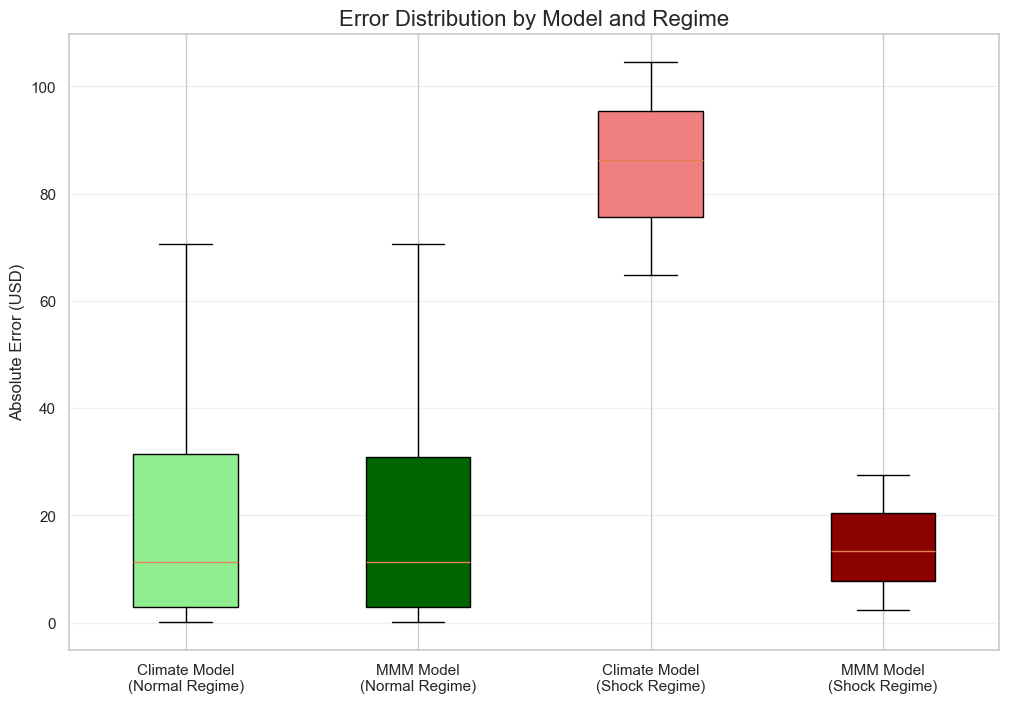

In [74]:
# Calculate absolute errors directly (no intermediate columns)
climate_normal = np.abs(normal_regime['Coffee_Price'] - normal_regime['Climate_Pred'])
climate_shock = np.abs(shock_regime['Coffee_Price'] - shock_regime['Climate_Pred']) 
mmm_normal = np.abs(normal_regime['Coffee_Price'] - normal_regime['MMM_Prediction'])
mmm_shock = np.abs(shock_regime['Coffee_Price'] - shock_regime['MMM_Prediction'])

# Create boxplot
plt.figure(figsize=(12, 8))
box_data = [climate_normal, mmm_normal, climate_shock, mmm_shock]
labels = ['Climate Model\n(Normal Regime)', 'MMM Model\n(Normal Regime)', 
          'Climate Model\n(Shock Regime)', 'MMM Model\n(Shock Regime)']
colors = ['lightgreen', 'darkgreen', 'lightcoral', 'darkred']

bplot = plt.boxplot(box_data, patch_artist=True, labels=labels, showfliers=False)

# Color boxes
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Absolute Error (USD)')
plt.title('Error Distribution by Model and Regime', fontsize=16)
plt.grid(axis='y', alpha=0.3)
plt.show()

## 9. Real-World Application: Early Warning System

The MMM can be used as an early warning system for detecting regime shifts in advance. Let's visualize how shipping signals and price momentum start changing before the climate model breaks down.

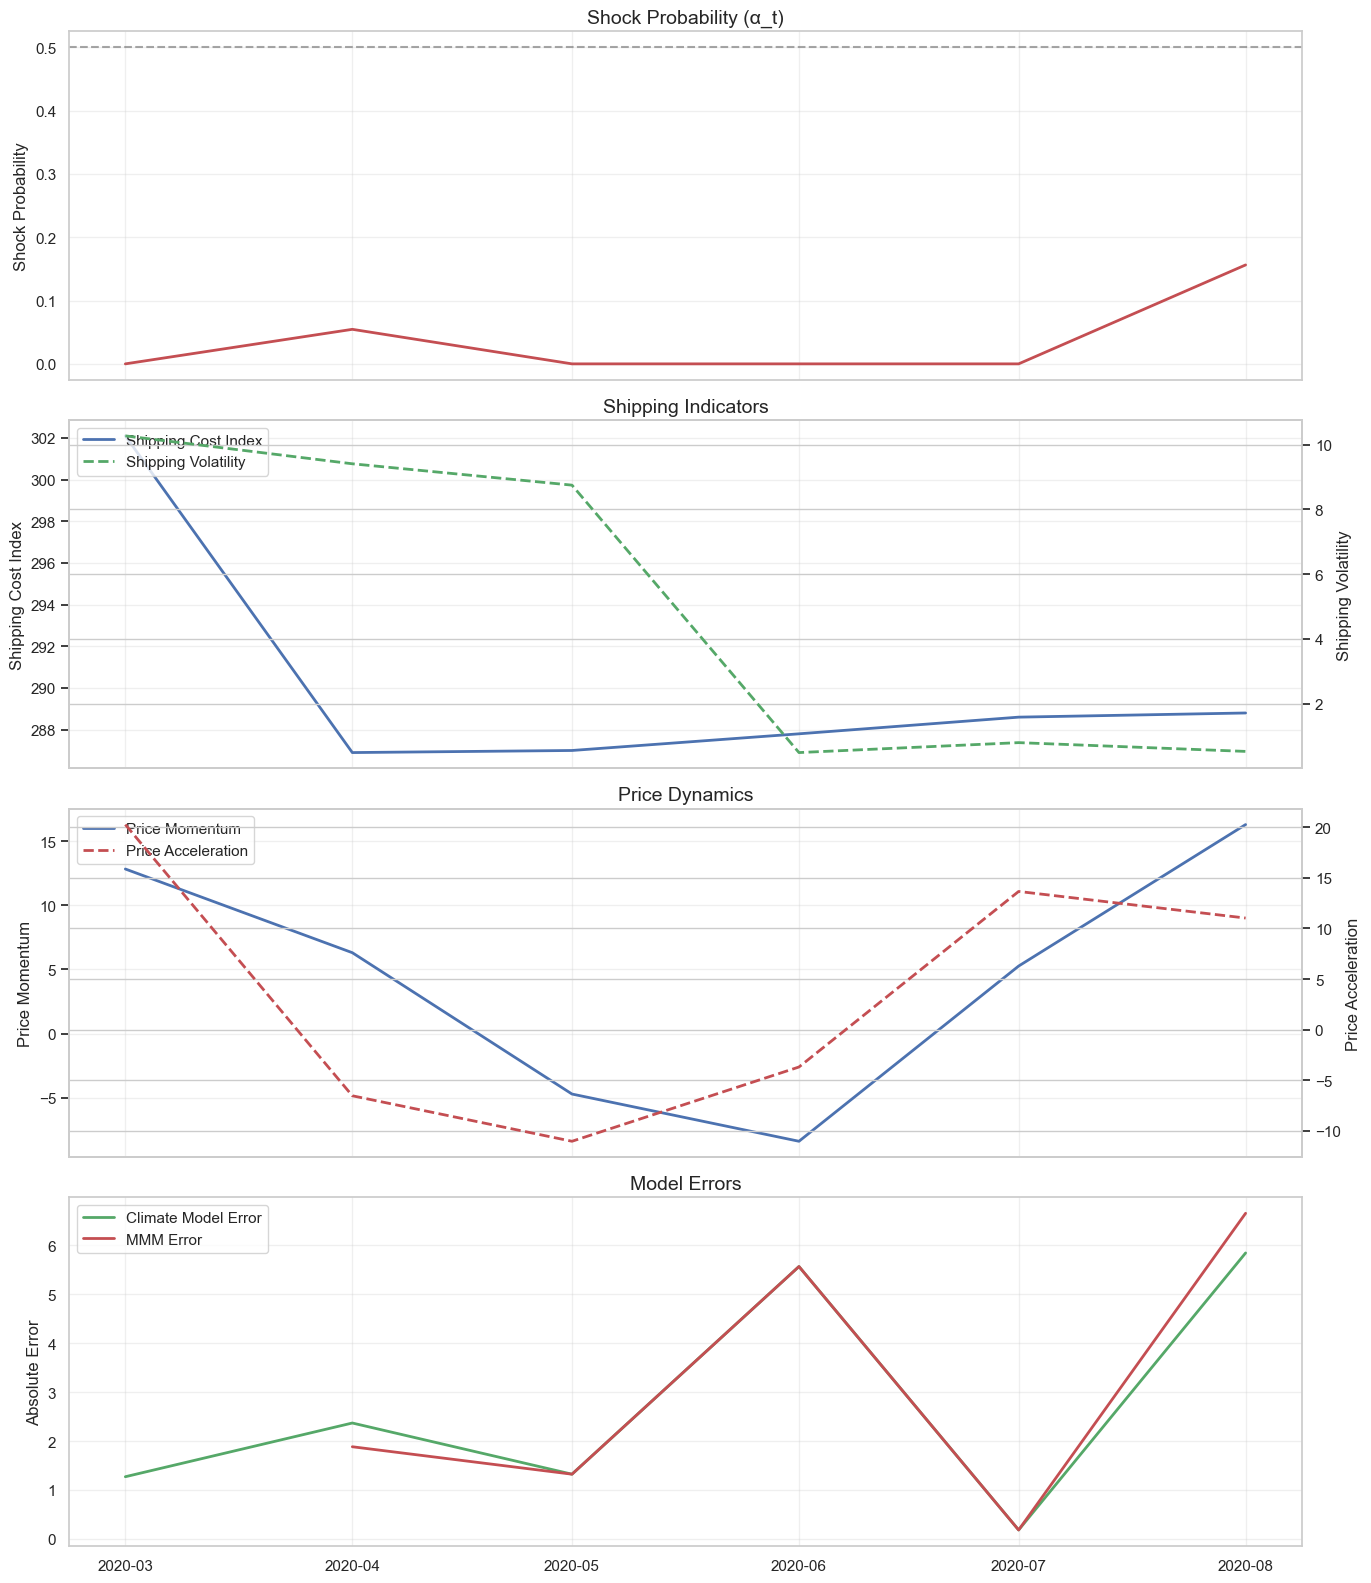

In [75]:
# Focus on the available transition period
# Since our data starts at 2020-03-01, we'll use the first 6 months as our early COVID period
covid_transition = coffee_df.iloc[:6].copy()

# Plot multiple indicators
fig, axes = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Plot 1: Model Shock Probability
axes[0].plot(covid_transition.index, covid_transition['Shock_Probability'], 'r-', linewidth=2)
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
axes[0].set_ylabel('Shock Probability')
axes[0].set_title('Shock Probability (α_t)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Plot 2: Shipping Cost and Volatility
ax2 = axes[1]
l1 = ax2.plot(covid_transition.index, covid_transition['Shipping_Cost_Index'], 'b-', linewidth=2, label='Shipping Cost Index')
ax2.set_ylabel('Shipping Cost Index')
ax2b = ax2.twinx()
l2 = ax2b.plot(covid_transition.index, covid_transition['Shipping_Cost_Volatility'], 'g--', linewidth=2, label='Shipping Volatility')
ax2b.set_ylabel('Shipping Volatility')
ax2.set_title('Shipping Indicators', fontsize=14)
ax2.grid(True, alpha=0.3)
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left')

# Plot 3: Price Momentum and Acceleration
ax3 = axes[2]
l1 = ax3.plot(covid_transition.index, covid_transition['Price_Momentum'], 'b-', linewidth=2, label='Price Momentum')
ax3.set_ylabel('Price Momentum')
ax3b = ax3.twinx()
l2 = ax3b.plot(covid_transition.index, covid_transition['Price_Acceleration'], 'r--', linewidth=2, label='Price Acceleration')
ax3b.set_ylabel('Price Acceleration')
ax3.set_title('Price Dynamics', fontsize=14)
ax3.grid(True, alpha=0.3)
lines = l1 + l2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left')

# Plot 4: Model Errors
error1 = np.abs(covid_transition['Coffee_Price'] - covid_transition['Climate_Pred'])
error2 = np.abs(covid_transition['Coffee_Price'] - covid_transition['MMM_Prediction'])
axes[3].plot(covid_transition.index, error1, 'g-', linewidth=2, label='Climate Model Error')
axes[3].plot(covid_transition.index, error2, 'r-', linewidth=2, label='MMM Error')
axes[3].set_ylabel('Absolute Error')
axes[3].set_title('Model Errors', fontsize=14)
axes[3].grid(True, alpha=0.3)
axes[3].legend(loc='upper left')

plt.tight_layout()
plt.show()

# Add a new cell to analyze model performance across all commodities

# Define function to run MMM model on any commodity
def run_mmm_for_commodity(commodity_name):
    # Filter to get only commodity-related variables and shipping indicators
    columns = [col for col in df.columns if commodity_name in col or 'Shipping' in col]
    commodity_df = df[columns].copy()
    
    # Handle missing values
    commodity_df = commodity_df.dropna()
    
    # Add momentum and acceleration features
    commodity_df['Price_Momentum'] = commodity_df[f'{commodity_name}_Price'].diff()
    commodity_df['Price_Acceleration'] = commodity_df['Price_Momentum'].diff()
    commodity_df['Price_Volatility'] = commodity_df[f'{commodity_name}_Price'].rolling(window=3).std()
    
    # Drop rows with NaN from the newly created features
    commodity_df = commodity_df.dropna()
    
    # If no data remains, return None
    if len(commodity_df) < 10:  # Minimum data points needed
        return None
    
    try:
        # Define climate features
        climate_features = [
            f'{commodity_name}_temp_anomaly', 
            f'{commodity_name}_drought_index', 
            f'{commodity_name}_precip_anomaly',
            f'{commodity_name}_temp_3m_avg', 
            f'{commodity_name}_precip_3m_sum', 
            f'{commodity_name}_heat_stress'
        ]
        
        # Use first half for training, second half for testing
        split_idx = len(commodity_df) // 2
        train_data = commodity_df.iloc[:split_idx]
        test_data = commodity_df.iloc[split_idx:]
        
        # Prepare X and y for training
        X_train = train_data[climate_features]
        y_train = train_data[f'{commodity_name}_Price']
        X_test = test_data[climate_features]
        y_test = test_data[f'{commodity_name}_Price']
        
        # Train the Random Forest model
        base_model = RandomForestRegressor(n_estimators=100, random_state=42)
        base_model.fit(X_train, y_train)
        
        # Make predictions
        y_train_pred = base_model.predict(X_train)
        y_test_pred = base_model.predict(X_test)
        
        # Store predictions
        commodity_df.loc[train_data.index, 'Climate_Pred'] = y_train_pred
        commodity_df.loc[test_data.index, 'Climate_Pred'] = y_test_pred
        
        # Calculate residuals and define shock regime
        commodity_df['Residual'] = commodity_df[f'{commodity_name}_Price'] - commodity_df['Climate_Pred']
        threshold = 1.5 * commodity_df['Residual'].std()
        commodity_df['Shock_Regime'] = (commodity_df['Residual'].abs() > threshold).astype(int)
        
        # Define meta-model features
        meta_features = [
            'Price_Momentum', 'Price_Acceleration', 'Price_Volatility',
            'Shipping_Cost_Change', 'Shipping_Cost_Acceleration', 'Shipping_Cost_Volatility'
        ]
        
        # Train meta-model to predict shocks
        X_meta = commodity_df[meta_features]
        y_meta = commodity_df['Shock_Regime']
        
        meta_model = LogisticRegression(random_state=42)
        meta_model.fit(X_meta, y_meta)
        
        # Predict shock probabilities
        shock_probs = meta_model.predict_proba(X_meta)[:, 1]
        commodity_df['Shock_Probability'] = shock_probs
        
        # Create momentum model
        commodity_df['Momentum_Pred'] = commodity_df[f'{commodity_name}_Price'].shift(1) + commodity_df['Price_Momentum'].shift(1)
        
        # Blend predictions
        commodity_df['MMM_Prediction'] = (
            (1 - commodity_df['Shock_Probability']) * commodity_df['Climate_Pred'] + 
            commodity_df['Shock_Probability'] * commodity_df['Momentum_Pred']
        )
        
        # Drop NaN values from the predictions
        commodity_df_valid = commodity_df.dropna(subset=['MMM_Prediction'])
        
        # Calculate performance metrics
        climate_rmse = np.sqrt(mean_squared_error(commodity_df_valid[f'{commodity_name}_Price'], commodity_df_valid['Climate_Pred']))
        momentum_rmse = np.sqrt(mean_squared_error(commodity_df_valid[f'{commodity_name}_Price'], commodity_df_valid['Momentum_Pred']))
        mmm_rmse = np.sqrt(mean_squared_error(commodity_df_valid[f'{commodity_name}_Price'], commodity_df_valid['MMM_Prediction']))
        
        return {
            'Commodity': commodity_name,
            'Climate Model RMSE': climate_rmse,
            'Momentum Model RMSE': momentum_rmse,
            'MMM Model RMSE': mmm_rmse,
            'MMM Improvement over Climate (%)': (1 - mmm_rmse/climate_rmse) * 100,
            'Momentum Best of All?': momentum_rmse < mmm_rmse,
            'Sample Size': len(commodity_df_valid)
        }
    except Exception as e:
        print(f"Error processing {commodity_name}: {str(e)}")
        return None

# Get all commodity names from the dataset
commodities = ['Coffee', 'Wheat', 'Cocoa', 'Rice', 'Soybeans', 'Maize', 'Cotton']

# Run the model for each commodity
all_results = []
for commodity in commodities:
    print(f"Processing {commodity}...")
    result = run_mmm_for_commodity(commodity)
    if result:
        all_results.append(result)

# Create a DataFrame from results
all_commodity_results = pd.DataFrame(all_results)
all_commodity_results.set_index('Commodity', inplace=True)

# Display results
print("\nPerformance Across All Commodities:")
all_commodity_results